# Pytorch LSTM: Sine wave prediction

### Purely for demonstration purposes, a FC network outperforms an LSTM here.

### [A Pytorch replication of the Tensorflow example found here](https://www.kaggle.com/code/carlmcbrideellis/lstm-time-series-prediction-sine-wave-example)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
X_train = np.arange(0,100,0.5) 
y_train = np.sin(X_train)

X_test = np.arange(100,200,0.5) 
y_test = np.sin(X_test)

n_features = 1

train_series = y_train
test_series  = y_test

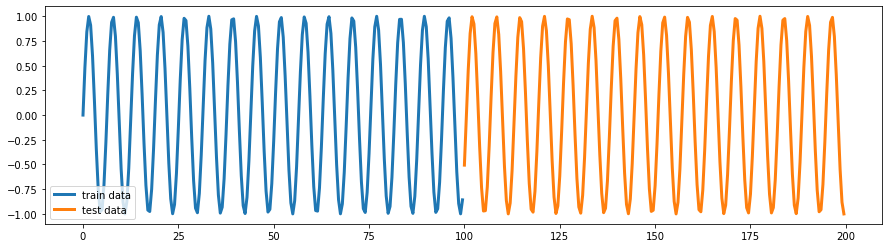

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.plot(X_train,y_train, lw=3, label='train data')
ax.plot(X_test, y_test,  lw=3, label='test data')
ax.legend(loc="lower left")
plt.show();

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

## Need to convert numpy arrays to Torch tensors

In [5]:
train_series = torch.from_numpy(train_series)
test_series = torch.from_numpy(test_series)

#### Original Tensorflow code used batches of size 10, but this isn't correct. Sequences should always be passed in their entirety to an RNN if possible, otherwise the network cannot properly learn to utilize it's *cell*/*hidden* state. As such, with only a single sequence, we pass the entire sequence to the LSTM.

#### The reason the network still works with this interupted batched sequence is because the sequence is repetitive and stable. If the sequence took longer than 20 time steps to loop, the network would almost certainly fail.

In [ ]:
# LSTM expects input of (batch, sequence, features)
# So shape should be (1, 179, 20) and labels (1, 1, 179)
# look_back = 20
look_back = 5

train_dataset = []
train_labels = []
for i in range(len(train_series)-look_back):
    train_dataset.append(train_series[i:i+look_back])
    train_labels.append(train_series[i+look_back])
train_dataset = torch.stack(train_dataset).unsqueeze(0)
train_labels = torch.stack(train_labels).unsqueeze(0).unsqueeze(2)

In [ ]:
class Net(nn.Module):
    def __init__(self, n_neurons, input_shape):
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(input_shape, n_neurons)
        self.lstm = nn.LSTM(input_size=input_shape, hidden_size=n_neurons)
        self.fc = nn.Linear(n_neurons, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc1(x)
        out = self.fc(out)
        return out

In [ ]:
train_labels.shape

## Training

In [ ]:
n_neurons = 4

model = Net(n_neurons, look_back).double()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_curve = []
for epoch in tqdm(range(300)):
    loss_total = 0
    
    model.zero_grad()
    
    predictions = model(train_dataset)
    
    loss = loss_function(predictions, train_labels)

    loss_total += loss.item()
    loss.backward()
    optimizer.step()
    loss_curve.append(loss_total)

In [ ]:
n_neurons = 4

model = Net(n_neurons, look_back).double()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_curve = []
for epoch in tqdm(range(300)):
    loss_total = 0
    
    model.zero_grad()
    
    predictions = model(train_dataset)
    
    loss = loss_function(predictions, train_labels)
    loss_total += loss.item()
    loss.backward()
    optimizer.step()
    loss_curve.append(loss_total)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(loss_curve, lw=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("Training Loss (MSE)")
plt.show()

## Prediction

In [ ]:
# LSTM expects input of (batch, sequence, features)
# So shape should be (1, 179, 20)
test_dataset = [test_series[i:i+look_back] for i in range(len(train_series)-look_back)]
test_dataset = torch.stack(test_dataset).unsqueeze(0)

with torch.no_grad():
    test_predictions = model(test_dataset).squeeze()

In [ ]:
x = np.arange(100+look_back*0.5,200,0.5)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(X_train,y_train, lw=2, label='train data')
ax.plot(X_test,y_test, lw=3, c='y', label='test data')
ax.plot(x,test_predictions, lw=3, c='r',linestyle = ':', label='predictions')
ax.legend(loc="lower left")
plt.show();

## Extrapolation

In [14]:
extrapolation = []
seed_batch = test_series[:look_back].reshape(1, 1, look_back)
current_batch = seed_batch
with torch.no_grad():
    for i in range(180):
        predicted_value = model(current_batch)
        extrapolation.append(predicted_value.item())
        current_batch = torch.cat((current_batch[:,:,1:], predicted_value), axis=2)

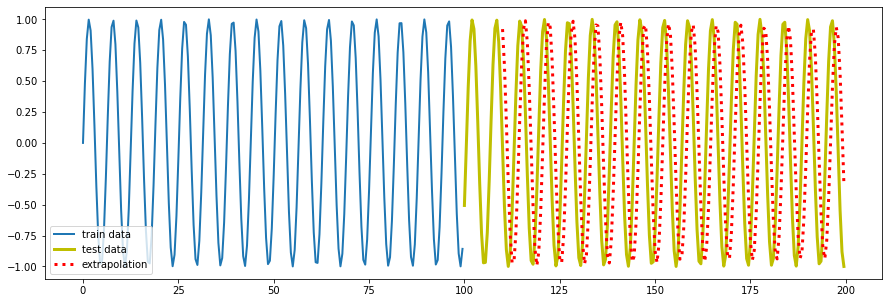

In [15]:
x = np.arange(110,200,0.5)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(X_train,y_train, lw=2, label='train data')
ax.plot(X_test,y_test, lw=3, c='y', label='test data')
ax.plot(x,extrapolation, lw=3, c='r',linestyle = ':', label='extrapolation')
ax.legend(loc="lower left")
plt.show();

## Sine wave + 3rd harmonic + 5th harmonic
Let us complicate things a little by now adding the third and fifth harmonics to the input data

In [16]:
X_train = np.arange(0,50,0.5) 
y_train = np.sin(X_train) + np.sin(3*X_train)/3 + np.sin(5*X_train)/5

X_test  = np.arange(50,100,0.5) 
y_test  = np.sin(X_train) + np.sin(3*X_train)/3 + np.sin(5*X_train)/5

train_series = y_train
test_series  = y_test

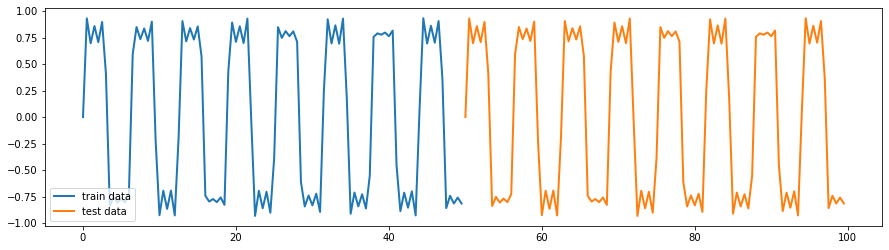

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.plot(X_train,y_train, lw=2, label='train data')
ax.plot(X_test, y_test,  lw=2, label='test data')
ax.legend(loc="lower left")
plt.show();

In [18]:
train_series = torch.from_numpy(train_series)
test_series = torch.from_numpy(test_series)

In [19]:
# LSTM expects input of (batch, sequence, features)
# So shape should be (1, 179, 20) and labels (1, 1, 179)
# look_back = 20
look_back = 1

train_dataset = []
train_labels = []
for i in range(len(train_series)-look_back):
    train_dataset.append(train_series[i:i+look_back])
    train_labels.append(train_series[i+look_back])
train_dataset = torch.stack(train_dataset).unsqueeze(0)
train_labels = torch.stack(train_labels).unsqueeze(0).unsqueeze(2)

## Training

In [20]:
model = Net(n_neurons, look_back).double() # Need to recreate model and optimizer to reset hidden values
optimizer = optim.Adam(model.parameters(), lr=0.003) # Higher learning rate used for more complicated task to get similar performance in similar epochs
loss_curve = []
for epoch in range(300):
    loss_total = 0
    
    model.zero_grad()
    
    predictions = model(train_dataset)
    
    loss = loss_function(predictions, train_labels)
    loss_total += loss.item()
    loss.backward()
    optimizer.step()
    loss_curve.append(loss_total)

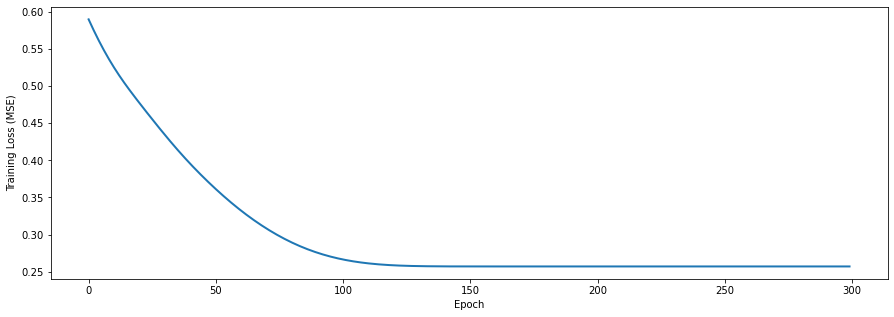

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(loss_curve, lw=2)
ax.set_xlabel("Epoch")
ax.set_ylabel("Training Loss (MSE)")
plt.show()

## Prediction

In [22]:
# LSTM expects input of (batch, sequence, features)
# So shape should be (1, 179, 20)
test_dataset = [test_series[i:i+look_back] for i in range(len(train_series)-look_back)]
test_dataset = torch.stack(test_dataset).unsqueeze(0)

with torch.no_grad():
    test_predictions = model(test_dataset).squeeze()

#### This is where the aforementioned batch detail is vital. With a more complicated sequence, using a disjointed sequence hinders the LSTM. As a continuous sequence is being used here, the LSTM performs much better

ValueError: x and y must have same first dimension, but have shapes (80,) and torch.Size([99])

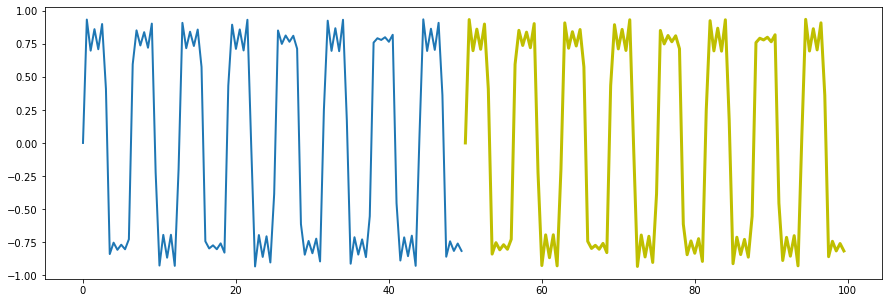

In [23]:
x = np.arange(60,100,0.5)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(X_train,y_train, lw=2, label='train data')
ax.plot(X_test,y_test, lw=3, c='y', label='test data')
ax.plot(x,test_predictions, lw=3, c='r',linestyle = ':', label='predictions')
ax.legend(loc="lower left")
plt.show();

## Extrapolation

In [ ]:
extrapolation = []
seed_batch = test_series[:look_back].reshape(1, 1, look_back)
current_batch = seed_batch
with torch.no_grad():
    for i in range(400):
        predicted_value = model(current_batch)
        extrapolation.append(predicted_value.item())
        current_batch = torch.cat((current_batch[:,:,1:], predicted_value), axis=2)

In [ ]:
x = np.arange(60,260,0.5)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(X_train,y_train, lw=2, label='train data')
ax.plot(X_test,y_test, lw=3, c='y', label='test data')
ax.plot(x,extrapolation, lw=1, c='r', label='extrapolation')
ax.legend(loc="lower left")
plt.show();

### And so you got to the end! Wanna know the coolest part?

# This was all done using only a standard FC neural network. No LSTM needed.

### If you want to see this code with an LSTM, uncomment the `self.lstm` and `out, _` lines in the `Net` class, and comment out the lines with `self.fc1` in them.

### I'd recommend raising the learning rates or epochs if you use an LSTM, it requires a bit more training